<a href="https://colab.research.google.com/github/MariiaKalinina/BM/blob/main/Pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.integrate import odeint

import cv2
from google.colab.patches import cv2_imshow

# 2.2.1 Basic Formulation

## Hydrostatic and Lithostatic Pressure, p.38

In [2]:
# Constants
g = 9.81  # gravitational acceleration in m/s^2
rho_sea = 1100  # density of sea water in kg/m^3
rho_w = 1040  # density of pore water in kg/m^3
rho_shale = 2700  # density of shale in kg/m^3
rho_sandstone = 2720  # density of sandstone in kg/m^3
water_depth = 1000  # water depth hw = 1 km in meters

In [3]:
def hydrostatic_pressures(depths, sea_level, sediment_surface, water_depth, rho_water=1040):

    """
    Calculate cumulative hydrostatic pressures for each layer.

    Parameters:
    - depths: List or array of bottom depth of each layer (m)
    - water_depth: Depth of water (m)
    - sediment_surface: Depth of sediment surface (m)
    - rho_water: Constant value of sea water density (kg/m^3)

    Returns:
    - List of cumulative pressures (MPa) for each layer and depth array
    """

    g = 9.81  # acceleration due to gravity in m/s^2
    pressures = [quad(lambda z: rho_water * g, sea_level, depth)[0] / 1e6 for depth in depths]  # Convert Pa to MPa

    return pressures

In [4]:
def lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level,
                          water_depth, sediment_surface):
    """
    Calculate cumulative lithostatic pressures for each layer.

    Parameters:
    - layer_thicknesses: List or array of thicknesses of each layer (m)
    - rock_densities: List or array of densities of each rock layer (kg/m^3)
    - porosities: List or array of porosity values for each layer (fraction)
    - water_depth: Constant value of a water depth (m)

    Returns:
    - List of cumulative pressures (MPa) for each layer
    """
    g = 9.81  # acceleration due to gravity in m/s^2
    rho_sea = 1100
    pressures = []
    total_depth = 0
    total_pressure = 0

    if sediment_surface < 0:

      filtered_depths = np.insert(layer_bottom_depth, 0, sediment_surface)
      rock_densities = np.insert(rock_densities, 0, 0)
      porosities = np.insert(porosities, 0, 0)    # Add sediment porosity at the start


      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):
        total_pressure = 0
        effective_density = density * (1 - porosity) + rho_sea*porosity

        water_pressure = rho_sea * g * water_depth
        pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
        total_pressure += water_pressure
        total_pressure += pressure_increment

        pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

    else:

      filtered_depths = [depth for depth in layer_bottom_depth if depth > sediment_surface]
      filtered_depths.insert(0, sediment_surface)

      for depth, density, porosity in zip(filtered_depths, rock_densities, porosities):

          total_pressure = 0
          effective_density = density * (1 - porosity) + rho_sea*porosity

          water_pressure = rho_sea * g * water_depth
          pressure_increment = quad(lambda z: effective_density * g, sediment_surface, depth)[0]
          total_pressure += water_pressure
          total_pressure += pressure_increment

          pressures.append((total_pressure) / 1e6)  # Convert Pa to MPa

      return pressures

Hydrostatic pressures (MPa): [0.0, 15.303599999999996, 30.60719999999999, 45.910799999999995, 61.21439999999998]
Lithostatic pressures (MPa): [10.791, 24.0345, 63.76499999999999, 103.49549999999998, 143.226]


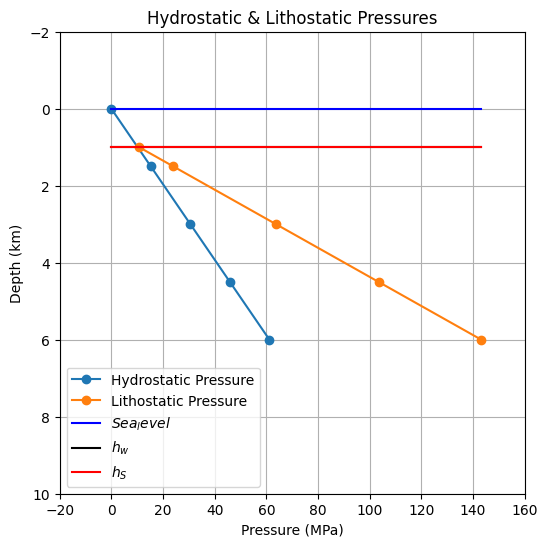

([0.0,
  15.303599999999996,
  30.60719999999999,
  45.910799999999995,
  61.21439999999998],
 [10.791, 24.0345, 63.76499999999999, 103.49549999999998, 143.226])

In [5]:
def pressure(pressure_types):

    SEA_LEVEL = 0
    SEDIMENT_SURFACE = 1000

    # Make initial data for calculation
    N = 5
    layer_bottom_depth = np.linspace(0, 6000, N)  # thickness of each layer in meters
    rock_densities = np.full(N, 2700)  # density of each rock layer in kg/m^3
    porosities = np.full(N, 0.0)  # porosity of each layer

    if SEDIMENT_SURFACE >=0:
      WATER_DEPTH = SEDIMENT_SURFACE
    else:
      WATER_DEPTH = SEA_LEVEL


    if 'hydrostatic' in pressure_types:
        pressures_hydrostatic = hydrostatic_pressures(layer_bottom_depth,
                                                      sea_level = SEA_LEVEL,
                                                      sediment_surface = SEDIMENT_SURFACE,
                                                      water_depth=WATER_DEPTH)
        print("Hydrostatic pressures (MPa):", pressures_hydrostatic)

    if 'lithostatic' in pressure_types:
        lith_pressures = lithostatic_pressures(layer_bottom_depth, rock_densities, porosities, sea_level=SEA_LEVEL,
                                               water_depth=WATER_DEPTH, sediment_surface=SEDIMENT_SURFACE)

        print("Lithostatic pressures (MPa):", lith_pressures)


    # Visualization

    plt.figure(figsize=(6, 6))
    ax1 = plt.subplot(1, 1, 1)

    if 'hydrostatic' in pressure_types:
        plt.plot(pressures_hydrostatic, layer_bottom_depth / 1000, label='Hydrostatic Pressure', marker='o')  # Convert depths to km
    if 'lithostatic' in pressure_types:

        if SEDIMENT_SURFACE < 0:
          depth_new = np.insert(layer_bottom_depth/1000, 0, SEDIMENT_SURFACE/1000)
          plt.plot(lith_pressures, depth_new, label='Lithostatic Pressure', marker='o')  # Convert layer depths to km
        else:
          depth_new = [depth/1000 for depth in layer_bottom_depth if depth > SEDIMENT_SURFACE]
          depth_new.insert(0, np.abs(SEDIMENT_SURFACE/1000))
          plt.plot(lith_pressures, depth_new, label='Lithostatic Pressure', marker='o')  # Convert layer depths to km


    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [SEA_LEVEL*1e-3, SEA_LEVEL*1e-3], color='blue', label=f'$Sea_level$') # Sea water level (hw)

    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [WATER_DEPTH*1e-3, WATER_DEPTH*1e-3], color='black', label=f'$h_w$') # Sea water level (hw)

    plt.plot([np.min(pressures_hydrostatic), np.max(lith_pressures)],
     [SEDIMENT_SURFACE*1e-3, SEDIMENT_SURFACE*1e-3], color='RED', label=f'$h_S$') # Surface level (hs)


    plt.title('Hydrostatic & Lithostatic Pressures')
    plt.ylabel('Depth (km)')
    plt.xlabel('Pressure (MPa)')
    plt.ylim(10, -2)  # Set limits after converting depths to km
    plt.xlim([np.min(pressures_hydrostatic), np.max(lith_pressures)])
    plt.xlim(-20, 160)
    plt.legend()
    plt.grid(True)
    plt.show()

    return pressures_hydrostatic, lith_pressures

pressure(['hydrostatic', 'lithostatic'])

# Pore Pressure: Terzaghi Type Models

### Initial parametrs for lithology types

In [20]:
sandstone = {
    'porosity initial': 0.41,
    'decline angle': 0.0266,
    'k': 0.0266,
    'rock density': 2720,
    'compaction parameter': 0.31, #km-1
    'C0': 27.5,
    'Cm' : 1.15,
    'ka': 41.56, #GPa-1
    'kb': 17.81, #GPa-1
    'phi1': 0.20

}

shale = {
    'porosity initial': 0.70,
    'decline angle': 0.096,
    'k': 0.096,
    'rock density': 2700,
    'compaction parameter': 0.83, #km-1
    'C0': 403,
    'Cm' : 4.03,
    'ka': 191.57, #GPa-1
    'kb': 52.70, #GPa-1
    'phi1': 0.35
}

siltstone = {
    'porosity initial': 0.55,
    'decline angle': 0.049,
    'k': 0.049,
    'rock density': 2720,
    'compaction parameter': 0.51, #km-1
    'C0': 103,
    'Cm' : 2.11,
    'ka': 31.65, #GPa-1
    'kb': 86.11, #GPa-1
    'phi1': 0.28
}


# Create a list of the porosity values
porosity_values = [
    shale['porosity initial'],
    siltstone['porosity initial'],
    sandstone['porosity initial']
]

# Find the maximum porosity value
max_porosity = max(porosity_values)

min(porosity_values),max(porosity_values)


(0.41, 0.7)


## Athy’s Law formulated with Effective Stress

In [14]:
# image = cv2.imread('/content/Снимок экрана 2024-11-23 в 18.40.45.png')
# cv2_imshow(image)

Eq. (2.20)

Eng

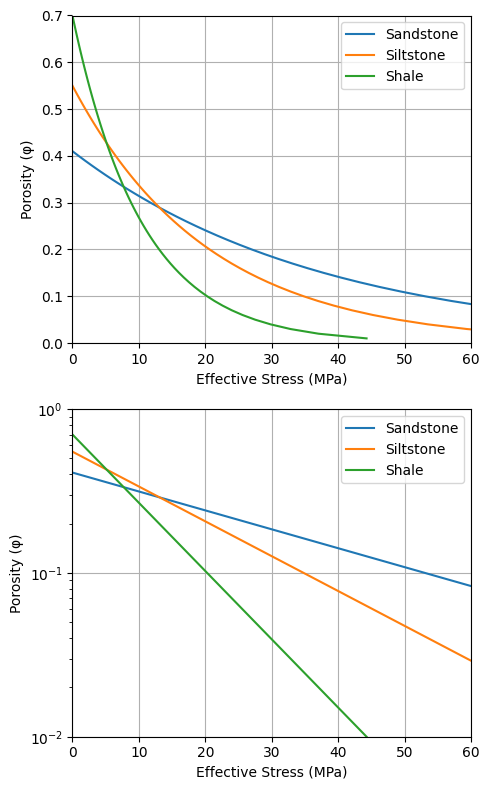

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def arty_model(phi_array, phi0, k):
    if phi0 <= 0 or k <= 0:
        raise ValueError("phi0 and k must be positive values.")

    return [- (1 / k) * np.log(phi / phi0) for phi in phi_array]


# List of lithology types
lithology_types = ['sandstone', 'siltstone', 'shale']

# Prepare the plot
plt.figure(figsize=(5, 8))

# Porosity array
phi_array = np.linspace(0.01, 1, 100)  # Start from a small positive value to avoid log(0)

# Iterate through each lithology type and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['k']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['k']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['k']

    # Calculate effective stress for the current lithology
    sigma_effective = arty_model(phi_array, phi0, k)

    # Plotting effective stress against porosity in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(sigma_effective, phi_array, label=f'{lithology.capitalize()}')
    # plt.title('Effective Stress vs Porosity (Linear Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.7)
    plt.grid(True)
    plt.legend()

    # Plotting effective stress against porosity in logarithmic scale
    plt.subplot(2, 1, 2)
    plt.plot(sigma_effective, phi_array, label=f'{lithology.capitalize()}')
    # plt.title('Effective Stress vs Porosity (Log Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0.01, 1)  # Avoid log(0) by starting from a small positive value
    plt.yscale('log')   # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('Athy’s Law formulated with Effective Stress_Porosity.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

Eq. (2.23)

Eng

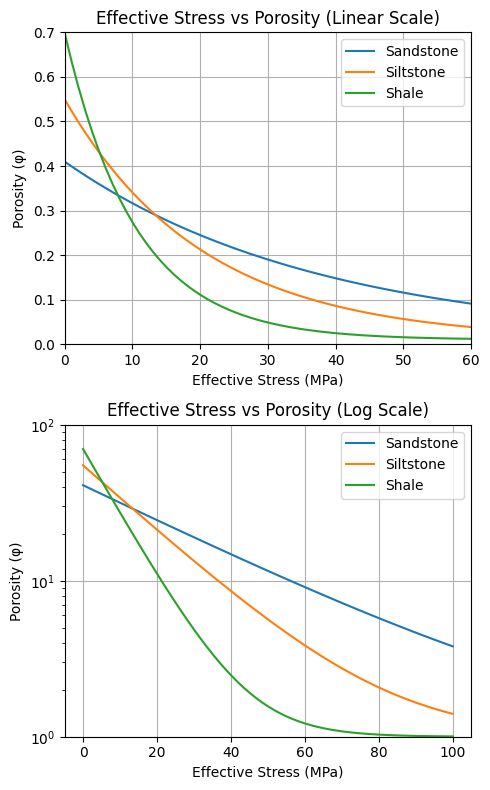

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def arty_model_porosity(sigma_z_array, phi0, phi_m, k):
    return [phi_m + (phi0 - phi_m) * np.exp(-k * sigma_z) for sigma_z in sigma_z_array]

# Example lithology data
sandstone = {'porosity initial': 0.41, 'k': 0.0266}
siltstone = {'porosity initial': 0.55, 'k': 0.049}
shale = {'porosity initial': 0.70, 'k': 0.096}

# List of lithology types
lithology_types = ['sandstone', 'siltstone', 'shale']

# Prepare the plot
plt.figure(figsize=(5, 8))

# Effective stress array
sigma_z_array = np.linspace(0., 100, 100)  # Effective stress in MPa
phi_m = 0.01  # Minimum porosity

# Iterate through each lithology type and calculate porosity
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['k']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['k']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['k']

    # Calculate effective porosity for the current lithology
    porosity_effective = arty_model_porosity(sigma_z_array, phi0, phi_m, k)

    # Plotting effective stress against porosity in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(sigma_z_array, porosity_effective, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Linear Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.7)
    plt.grid(True)
    plt.legend()

    # Plotting effective stress against porosity in logarithmic scale
    plt.subplot(2, 1, 2)
    porosity_array = np.array(list(map(lambda x: x * 100, porosity_effective)))
    plt.plot(sigma_z_array, porosity_array, label=f'{lithology.capitalize()}')
    plt.title('Effective Stress vs Porosity (Log Scale)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    # plt.xlim(0, 60)
    plt.ylim(1, 100)  # Avoid log(0) by starting from a small positive value
    plt.yscale('log')   # Set y-axis to logarithmic scale
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

Eq.(2.25)

Eng

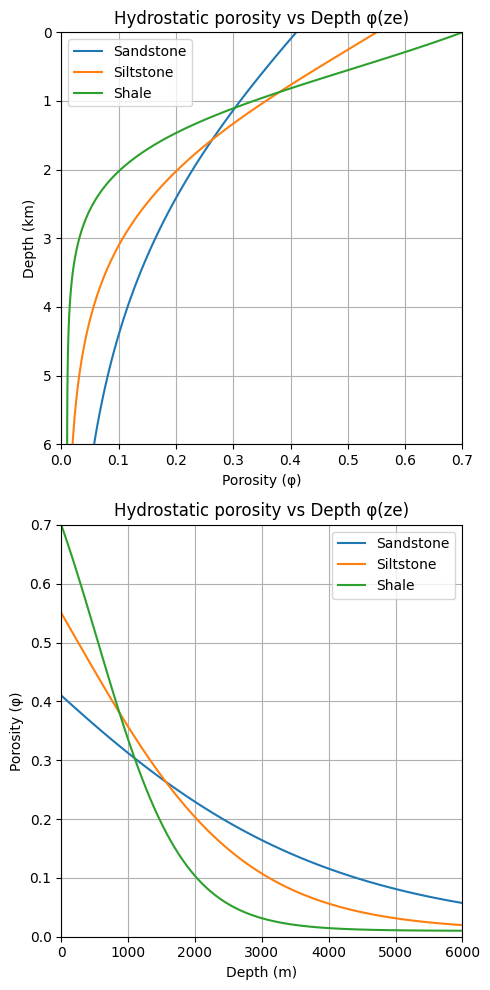

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def arty_model_porosity_ze(phi0, phi_m, k, ze_array, rho_rock, rho_water=1040, g=9.81):
    delta_rho = (rho_rock - rho_water) / 1000
    # Corrected the formula for effective porosity calculation
    return [
        ((phi0 - phi_m) + phi_m * (1 - phi0) * np.exp(k * (1 - phi_m) * delta_rho * g * ze)) /
        ((phi0 - phi_m) + (1 - phi0) * np.exp(k * (1 - phi_m) * delta_rho * g * ze))
        for ze in ze_array
    ]

# List of lithology types
lithology_types = ['sandstone', 'siltstone', 'shale']

# Prepare the plot
plt.figure(figsize=(5, 10))

# Effective depth array
ze_array = np.linspace(0, 6, 100)
phi_m = 0.01  # Minimum porosity

# Iterate through each lithology type and calculate porosity
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['k']
        rho = sandstone['rock density']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['k']
        rho = siltstone['rock density']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['k']
        rho = shale['rock density']

    # Calculate effective porosity for the current depth
    porosity_effective = arty_model_porosity_ze(phi0, phi_m, k, ze_array, rho)

    # Plotting the effective hydrostatic porosity against depth as function φ(ze) in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(porosity_effective, ze_array, label=f'{lithology.capitalize()}')
    plt.title('Hydrostatic porosity vs Depth φ(ze)')
    plt.ylabel('Depth (km)')
    plt.xlabel('Porosity (φ)')
    plt.ylim(np.max(ze_array), np.min(ze_array))
    plt.xlim(0,  max(porosity_values))
    plt.grid(True)
    plt.legend()

    # Plotting the effective hydrostatic porosity against depth as function φ(ze) in linear scale
    plt.subplot(2, 1, 2)
    plt.plot(ze_array*1000, porosity_effective,  label=f'{lithology.capitalize()}')
    plt.title('Hydrostatic porosity vs Depth φ(ze)')
    plt.xlabel('Depth (m)')
    plt.ylabel('Porosity (φ)')
    plt.xlim(np.min(ze_array)*1000, np.max(ze_array)*1000)
    plt.ylim(0,  max(porosity_values))
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('Athy’s Law formulated with Effective Stress_Depth.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

## Athy Model with Hydrostatic Depth

### Porosity vs Effective Stress

In [ ]:
# image = cv2.imread('/content/Снимок экрана 2024-11-23 в 18.33.35.png')
# cv2_imshow(image)

The inverse function φ(σz) can be calculated with the Newton iteration
method. The resulting porosity–effective stress curves are generally steeper in the high porosity and shallower in low porosity ranges than the Athy versus effective stress functions. Hence, they are more applicable for most rock types even though they are based on only one compaction parameter. The authors prefer this law as a default for most lithologies. Example compaction curves for clastic rocks and carbonates are illustrated in Fig. 2.8.

Eq.(2.28)

<ipython-input-23-7e1990e39182>:4: RuntimeWarning: invalid value encountered in log
  return (delta_rho * g / k) * (phi_array - phi0 - np.log(phi_array / phi0))


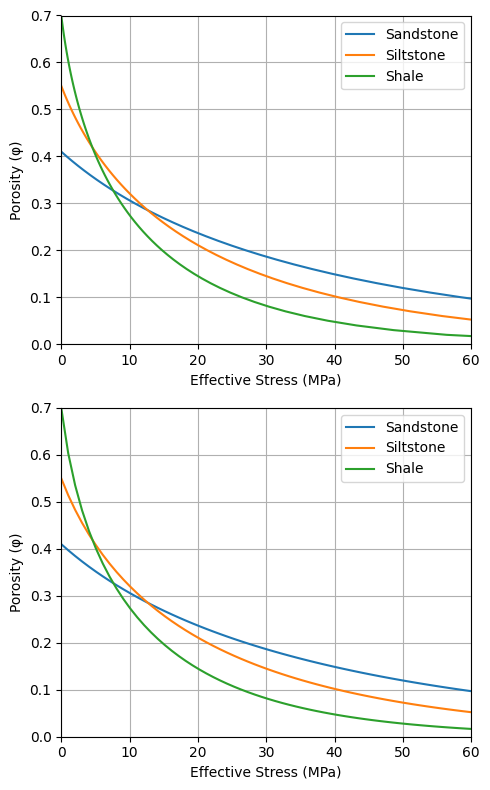

In [23]:
def effective_stress(phi_array, phi0, k, rho_rock, rho_water=1040, g=9.81):
    delta_rho = (rho_rock - rho_water) / 1000
    """Calculate effective stress based on the known porosity."""
    return (delta_rho * g / k) * (phi_array - phi0 - np.log(phi_array / phi0))

def porosity_from_stress(sigma, phi0, k, rho_rock, rho_water=1040, g=9.81, initial_guess=0.01, tol=1e-6, max_iter=100):
    """Calculate porosity from effective stress using Newton's method."""
    delta_rho = (rho_rock - rho_water) / 1000
    phi = initial_guess
    for _ in range(max_iter):
        # Calculate effective stress at current porosity
        sigma_current = effective_stress(np.array([phi]), phi0, k, rho_rock, rho_water, g)[0]

        # Calculate derivative (numerical approximation)
        d_sigma_d_phi = (effective_stress(np.array([phi + tol]), phi0, k, rho_rock, rho_water, g)[0] - sigma_current) / tol

        # Update porosity using Newton's method
        phi_new = phi - (sigma_current - sigma) / d_sigma_d_phi

        # Check for convergence
        if abs(phi_new - phi) < tol:
            return phi_new

        phi = phi_new

    return phi  # Return last computed value if not converged

lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities and effective stresses
phi_array = np.linspace(0.01, 1, 100)  # Start from a small positive value
sigma_array = np.linspace(0.01, 100, 100)  # Effective stress in MPa

plt.figure(figsize=(5, 8))

# Loop through each lithology and calculate effective stress and porosity from stress
for lithology in lithology_types:

    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['compaction parameter']
        rho = sandstone['rock density']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['compaction parameter']
        rho = siltstone['rock density']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['compaction parameter']
        rho = shale['rock density']

    # Calculate effective stress for the current lithology
    sigma_effective = effective_stress(phi_array, phi0=phi0, k=k, rho_rock=rho)

    # Calculate porosity from stress for the current sigma values
    porosity_from_stress_values = [porosity_from_stress(sigma_value, phi0=phi0, k=k, rho_rock=rho) for sigma_value in sigma_array]

    # Plotting

    # Plotting effective stress (calculated) against porosity (initial data) in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(sigma_effective , phi_array, label=f'{lithology.capitalize()}')
    # plt.title('Effective Stress (unknown) vs Porosity')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.70)
    plt.grid(True)
    plt.legend()

    # Plotting effective stress (initial data) against porosity (calculated) in linear scale
    plt.subplot(2, 1, 2)
    plt.plot(sigma_array , porosity_from_stress_values,label=f'{lithology.capitalize()}')
    # plt.title('Effective Stress vs Porosity (unknown)')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.xlim(0, 60)
    plt.ylim(0, 0.70)
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('Athy Model with Hydrostatic Depth_Porosity.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

### Porosity vs Depth

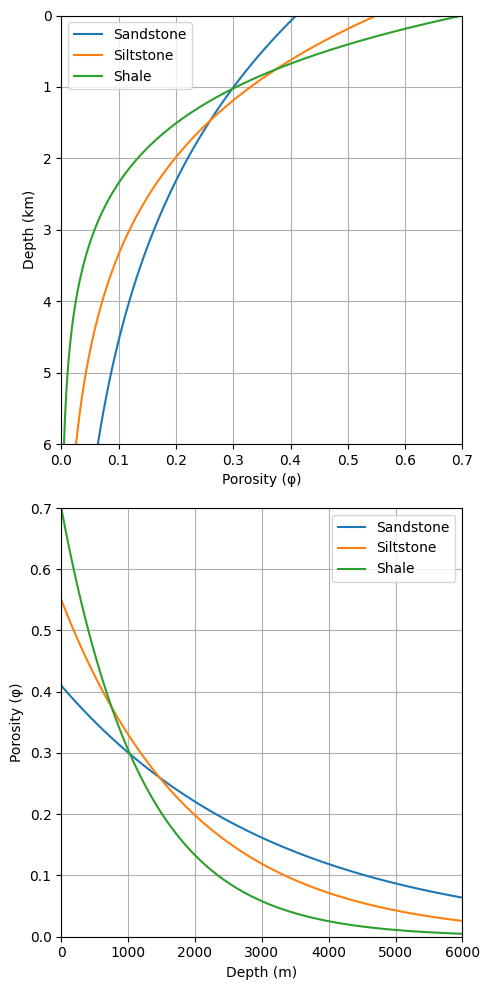

In [32]:
def porosity_from_depth(ze_array, phi0, k):
    """Calculate effective porosity from equivalent hydrostatic depth ze instead of the total depth"""
    return [phi0 * np.exp(-k*ze) for ze in ze_array]


lithology_types = ['sandstone', 'siltstone', 'shale']

plt.figure(figsize=(5, 10))

# Equivalent hydrostatic array
ze_array = np.linspace(0, 6, 100)

for lithology in lithology_types:

    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['compaction parameter']
        rho = sandstone['rock density']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['compaction parameter']
        rho = siltstone['rock density']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['compaction parameter']
        rho = shale['rock density']

    # Calculate effective porosity for the current depth
    porosity_effective = porosity_from_depth(ze_array, phi0, k)

    # Plotting the effective hydrostatic porosity against depth as function φ(ze) in linear scale
    plt.subplot(2, 1, 1)
    plt.plot(porosity_effective, ze_array, label=f'{lithology.capitalize()}')
    # plt.title('Hydrostatic porosity vs Depth φ(ze)')
    plt.ylabel('Depth (km)')
    plt.xlabel('Porosity (φ)')
    plt.ylim(np.max(ze_array), np.min(ze_array))
    plt.xlim(0,  max(porosity_values))
    plt.grid(True)
    plt.legend()

    # Plotting the effective hydrostatic porosity against depth as function φ(ze) in linear scale
    plt.subplot(2, 1, 2)
    plt.plot(ze_array*1000, porosity_effective,  label=f'{lithology.capitalize()}')
    # plt.title('Hydrostatic porosity vs Depth φ(ze)')
    plt.xlabel('Depth (m)')
    plt.ylabel('Porosity (φ)')
    plt.xlim(np.min(ze_array)*1000, np.max(ze_array)*1000)
    plt.ylim(0,  max(porosity_values))
    plt.grid(True)
    plt.legend()

# Show the plots
plt.tight_layout()
plt.savefig('Athy Model with Hydrostatic Depth_Depth.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

## Schneider Model

In [79]:
# Function to calculate porosity based on effective stress (Schneider's model)
def porosity_schneider(sigma_z, phi1, phia, phib, ka, kb):
    """Calculate porosity based on effective stress using Schneider's equation."""
    return phi1 + phia * np.exp(-ka * sigma_z) + phib * np.exp(-kb * sigma_z)

# Function to calculate dσz/dze
def sigma_z_from_depth(sigma_z, phi0, rho_rock,
                        rho_water=1040, g=9.81):
    """
    Numerically integrate the compressibility function to find sigma_z at a given depth z.
    """
    phi = phi0
    delta_rho = (rho_rock - rho_water)
    return delta_rho * g * (1 - phi)

# Define the compressibility function
def compressibility(sigma_z, phia, phib, ka, kb):
    """
    Calculate compressibility based on the effective stress sigma_z.
    """
    return ka * phia * np.exp(-ka * sigma_z) + kb * phib * np.exp(-kb * sigma_z)

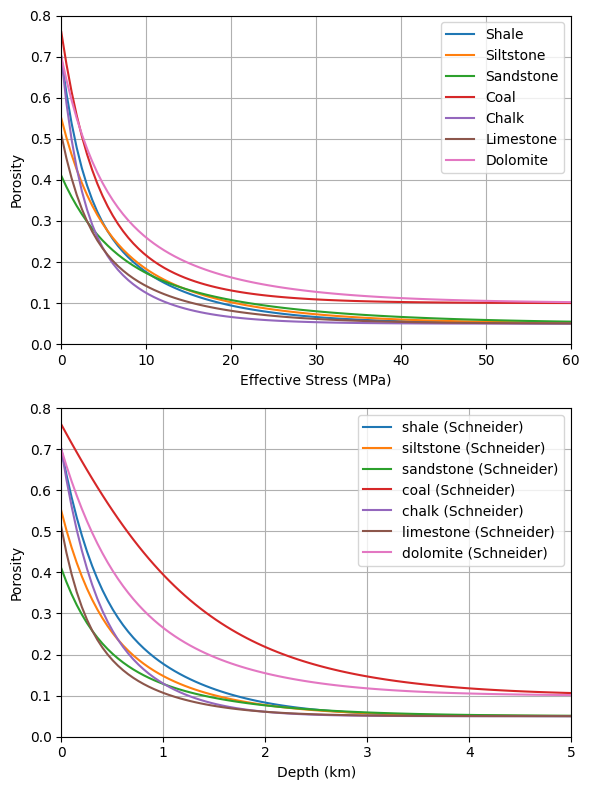

In [99]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def porosity_schneider(sigma_z, phi1, phia, phib, ka, kb):
    """Calculate porosity using Schneider's dual-exponential model"""
    return phi1 + phia * np.exp(-ka * sigma_z) + phib * np.exp(-kb * sigma_z)

def compressibility_schneider(sigma_z, phia, phib, ka, kb):
    """Calculate compressibility using Schneider's model"""
    return ka * phia * np.exp(-ka * sigma_z) + kb * phib * np.exp(-kb * sigma_z)

def sigma_z_from_depth(z, sigma_z, phi_func, rho):
    """Differential equation for effective stress with depth"""
    phi = phi_func(sigma_z)
    return rho * 9.81 * (1 - phi) * 1e-3  # Convert to MPa/km


# Lithology properties from Fig 2.8 (Athy's parameters)
lithologies = {
    'shale': {
        'phi0': 0.70,
        'k': 0.83,  # km⁻¹
        'rho': 2700,  # kg/m³
        'ka': 0.40,   # Approximate Schneider parameters
        'kb': 0.10,   # that match Athy's behavior
        'phi1': 0.05
    },
    'siltstone': {
        'phi0': 0.55,
        'k': 0.049,
        'rho': 2720,
        'ka': 0.25,
        'kb': 0.08,
        'phi1': 0.05
    },
    'sandstone': {
        'phi0': 0.41,
        'k': 0.31,
        'rho': 2600,
        'ka': 0.20,
        'kb': 0.06,
        'phi1': 0.05
    },
    'coal': {
        'phi0': 0.76,
        'k': 0.43,
        'rho': 1400,
        'ka': 0.30,
        'kb': 0.12,
        'phi1': 0.10
    },
    'chalk': {
        'phi0': 0.70,
        'k': 0.90,
        'rho': 2500,
        'ka': 0.50,
        'kb': 0.15,
        'phi1': 0.05
    },
    'limestone': {
        'phi0': 0.51,
        'k': 0.52,
        'rho': 2710,
        'ka': 0.35,
        'kb': 0.10,
        'phi1': 0.05
    },
    'dolomite': {
        'phi0': 0.70,
        'k': 0.39,
        'rho': 2850,
        'ka': 0.25,
        'kb': 0.08,
        'phi1': 0.10
    }
}

# Prepare plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

# 1. Porosity vs Effective Stress (Schneider model)
sigma_z_array = np.linspace(1e-3, 60, 100)  # MPa

for litho, props in lithologies.items():
    phi0 = props['phi0']
    phi1 = props['phi1']
    phia = phib = (phi0 - phi1)/2
    ka, kb = props['ka'], props['kb']

    porosity = porosity_schneider(sigma_z_array, phi1, phia, phib, ka, kb)
    ax1.plot(sigma_z_array, porosity, label=litho.capitalize())

# ax1.set_title('Schneider Model: Porosity vs Effective Stress')
ax1.set_xlabel('Effective Stress (MPa)')
ax1.set_ylabel('Porosity')
ax1.grid(True)
ax1.legend()
ax1.set_xlim(0, 60)
ax1.set_ylim(0, 0.8)

# 2. Porosity vs Depth (Hydrostatic conditions)
depth_range = np.linspace(0, 5, 100)  # km

for litho, props in lithologies.items():
    phi0 = props['phi0']
    k_athy = props['k']  # Athy's parameter (km⁻¹)
    rho = props['rho']

    # Athy's porosity-depth relationship for comparison
    phi_athy = phi0 * np.exp(-k_athy * depth_range)

    # Schneider model integration
    phi1 = props['phi1']
    phia = phib = (phi0 - phi1)/2
    ka, kb = props['ka'], props['kb']

    # Create porosity function for ODE
    def phi_func(sigma_z):
        return porosity_schneider(sigma_z, phi1, phia, phib, ka, kb)

    # Integrate from surface (z=0, σz=0)
    sigma_z = odeint(sigma_z_from_depth, 0, depth_range,
                    args=(phi_func, rho)).flatten()

    porosity_schneider_depth = phi_func(sigma_z)

    ax2.plot(depth_range, porosity_schneider_depth, '-', label=f'{litho} (Schneider)')
    # ax2.plot(depth_range, phi_athy, '--', label=f'{litho} (Athy)')

# ax2.set_title('Porosity vs Depth Comparison')
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Porosity')
# ax2.invert_xaxis()  # Depth increases downward
ax2.grid(True)
# ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.legend()
ax2.set_ylim(0, 0.8)
ax2.set_xlim(0, 5)

plt.tight_layout()
plt.savefig('Schneider Model.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

## Compressibility Model

In [ ]:
image = cv2.imread('/content/Снимок экрана 2024-11-23 в 22.24.56.png')
cv2_imshow(image)

In [28]:
def calculate_alpha(phi0, phim, Cm, C0):
    """
    Calculate alpha based on the given formula.
    """
    return np.exp((phi0 * np.log(Cm) - phim * np.log(C0)) / (phi0 - phim))


def calculate_beta(phi0, phim, Cm, C0):
    """
    Calculate alpha based on the given formula.
    """
    return (np.log(C0) - np.log(Cm)) / (phi0 - phim)


def effective_porosity_compresseibility_model(phi0, phim, Cm, C0, sigma_z):
    """
    Calculate effective porosity .

    """
    alpha = calculate_alpha(phi0, phim, Cm, C0)
    beta = calculate_beta(phi0, phim, Cm, C0)

    return -1/beta * np.log(alpha*beta*sigma_z + np.exp(-beta*phi0))



def compresseibility_compresseibility_model(phi0, phim, Cm, C0, sigma_z):
    """
    Calculate sigma_z based on the porosity function.

    """
    alpha = calculate_alpha(phi0, phim, Cm, C0)
    beta = calculate_beta(phi0, phim, Cm, C0)
    phi = effective_porosity_compresseibility_model(phi0, phim, Cm, C0, sigma_z)

    return alpha * (np.exp(beta * phi))


def effective_stress_compresseibility_model(phi, phi0, phim, Cm, C0):
    """
    Calculate sigma_z based on the porosity function.

    """
    alpha = calculate_alpha(phi0, phim, Cm, C0)
    beta = calculate_beta(phi0, phim, Cm, C0)

    return (np.exp(-beta * phi) - np.exp(-beta * phi0)) / (alpha * beta)

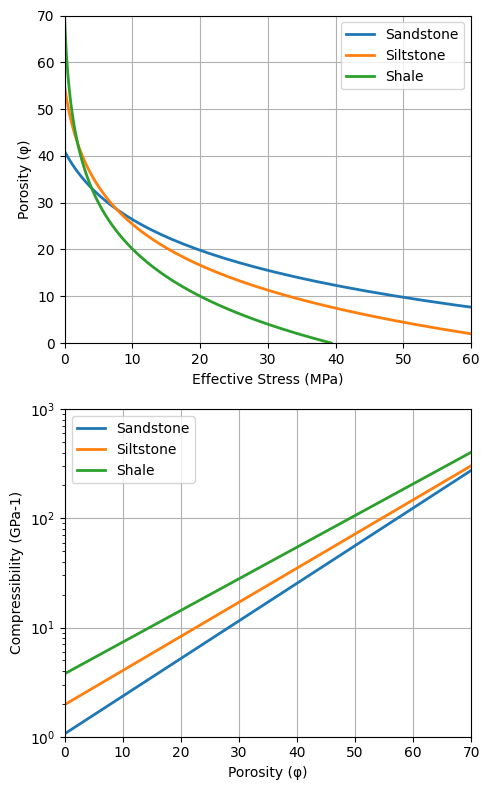

In [33]:
lithology_types = ['sandstone', 'siltstone', 'shale']

# Create an array of porosities
phi_array = np.linspace(0.0001, 1, 100)  # Start from a small positive value
phi_m=0.01

plt.figure(figsize=(5, 8))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        phi0 = sandstone['porosity initial']
        k = sandstone['decline angle']
        rho = sandstone['rock density'],
        C0 = sandstone['C0'],
        Cm = sandstone['Cm']
    elif lithology == 'siltstone':
        phi0 = siltstone['porosity initial']
        k = siltstone['decline angle']  # Corrected line: removed trailing comma
        rho = siltstone['rock density'],
        C0 = siltstone['C0'],
        Cm = siltstone['Cm']
    elif lithology == 'shale':
        phi0 = shale['porosity initial']
        k = shale['decline angle']
        rho = shale['rock density'],
        C0 = shale['C0'],
        Cm = shale['Cm']


    # Plotting
    sigma_effective = effective_stress_compresseibility_model(phi_array, phi0, phi_m, Cm, C0)

    plt.subplot(2, 1, 1)
    plt.plot(sigma_effective*1000, phi_array*100, label=f'{lithology.capitalize()}', linewidth=2)
    # plt.title('Effective Stress vs Porosity for Different Lithologies')
    plt.ylabel('Porosity (φ)')
    plt.xlabel('Effective Stress (MPa)')
    plt.grid(True)
    plt.xlim(0, 60)
    plt.ylim(0, 70)  # Adjusted to cover full range of porosity values
    plt.legend()


    plt.subplot(2, 1, 2)
    compressibility = [compresseibility_compresseibility_model(phi0, phi_m, Cm, C0, sigma_z) for sigma_z in sigma_effective]
    compressibility_array = np.concatenate(compressibility)
    plt.plot(phi_array*100, compressibility_array, label=f'{lithology.capitalize()}', linewidth=2)
    # print(compresseibility.flatten())
    # plt.title('Compressibility vs Porosity for Different Lithologies')
    plt.ylabel('Compressibility (GPa-1)')
    plt.xlabel('Porosity (φ)')
    plt.grid(True)
    plt.yscale('log')
    plt.xlim(0, 70)
    plt.ylim(10**0, 10**3)
    plt.legend()


plt.tight_layout()
plt.savefig('Compressibility Model_Porosity.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

## Mudstone Model

### Yang & Aplin 2004 Model

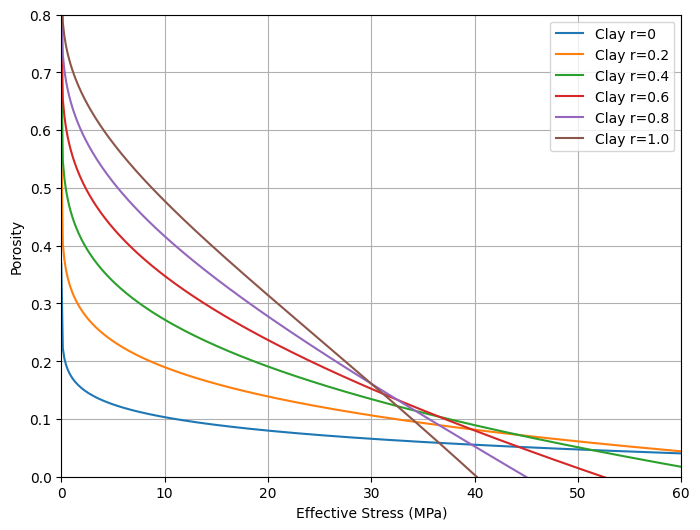

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import math

def e100(r):
    """Yang & Aplin (2004) initial void ratio"""
    return 0.3024 + 1.6867 * r + 1.9505 * r**2

def beta(r):
    """Yang & Aplin (2004) compressibility"""
    return 0.0937 + 0.5708 * r + 0.8483 * r**2

def calculate_porosity(sigma_z, r):
    """Correct porosity-stress relationship"""
    e_100 = e100(r)
    beta_val = beta(r)
    sigma_z = max(sigma_z, 1e-10)  # Avoid log(0)

    # Void ratio DECREASES with stress
    e = e_100 - beta_val * math.log10(sigma_z/0.1)

    return e / (1 + e)  # Porosity conversion

# Stress range and clay contents
sigma_values = np.linspace(1e-4, 60, 400)
r_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]

# Plotting
plt.figure(figsize=(8,6))
for r in r_values:
    porosities = [calculate_porosity(s, r) for s in sigma_values]
    plt.plot(sigma_values, porosities, label=f'Clay r={r}')

plt.xlabel('Effective Stress (MPa)')
plt.ylabel('Porosity')
# plt.title('Porosity vs. Effective Stress (Yang & Aplin 2004 Model)')
plt.xlim(0, 60)
plt.ylim(0, 0.8)  # Porosity should be between 0 and 1 (or 0% and 80%
plt.grid(True)
plt.legend()
plt.savefig('Mudstone Model_Yang & Aplin 2004.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.show()

### Lauvrak (2007) proposed the EasySoil model

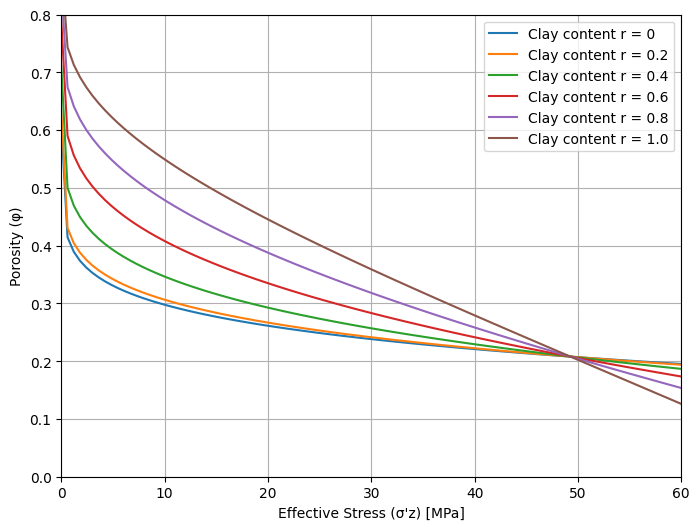

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import math

def e100_sample(r):
    """Sample-scale void ratio (e*_100) from Lauvrak (2007)."""
    return 0.725 - 0.252 * r + 2.53 * r**2

def beta_sample(r):
    """Sample-scale compressibility (β*) from Lauvrak (2007)."""
    return 0.218 - 0.119 * r + 1.193 * r**2

def e100_upscaled(r):
    """Upscaled void ratio (e100) for natural rocks."""
    e_star = e100_sample(r)
    beta_star = beta_sample(r)
    return e_star + 0.76 * beta_star

def beta_upscaled(r):
    """Upscaled compressibility (β) for natural rocks."""
    beta_star = beta_sample(r)
    return 1.07 * beta_star

def porosity(sigma_z, r):
    """Calculate porosity using upscaled parameters."""
    e100 = e100_upscaled(r)
    beta_val = beta_upscaled(r)

    # Avoid log(0) by clipping sigma_z to a small positive value
    sigma_z = max(sigma_z, 1e-10)

    # Calculate void ratio at current stress
    e = e100 - beta_val * math.log10(sigma_z / 0.1)

    # Convert void ratio to porosity
    phi = e / (1 + e)

    return phi

# Clay content values
r_values = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
sigma_values = np.linspace(1e-4, 60, 100)  # Effective stress range (MPa)

# Plotting
plt.figure(figsize=(8, 6))

for r in r_values:
    porosities = [porosity(sigma_z, r) for sigma_z in sigma_values]
    plt.plot(sigma_values, porosities, label=f'Clay content r = {r}')

plt.xlabel('Effective Stress (σ\'z) [MPa]')
plt.ylabel('Porosity (φ)')
# plt.title('Porosity vs. Effective Stress (EasySoil Model - Lauvrak 2007)')
plt.grid(True)
plt.xlim(0, 60)
plt.ylim(0, 0.8)  # Porosity should be between 0 and 1 (or 0% and 80%)
# plt.gca().invert_yaxis()  # Reverse y-axis to show decreasing porosity with depth
# plt.gca().invert_xaxis()
plt.savefig('Mudstone Model_Lauvrak 2007.tiff', format='tiff', dpi=300, bbox_inches='tight')
plt.legend()
plt.show()

# Model Comparison of Various Lithologies

###Shale

### Shale–sandstone mixtures

# Viscosity

The viscosity of saline water can be estimated from...

## Viscosity from McCain Jr. (1990)

In [29]:
def viscosity_McCain(s, T, P):
    """
    Calculate viscosity of saline water.

    Parameters:
    - s: Salinity (%), s < 26%
    - T: Temperature (°C), 38 < T < 200
    - P: Pressure (psi), P < 100 MPa

    Returns:
    - Viscosity (mPa·s) depending on temperature
    """
    a = 1.12166 - 2.63951 * 10**-2 * s + 6.79461 * 10**-4 * s**2 + 5.47119 * 10**-5 * s**3 - 1.55586 * 10**-6 * s**4
    vT = T**-a * (109.547 - 8.40564 * s + 0.313314 * s**2 + 8.72213 * 10**-3 * s**3)
    v = vT * (0.9994 + 4.0295 * 10**-5 * P + 3.1062 * 10**-9 * P**2)

    return v

def simplified_viscosity(T): # without salinity and pressure
    """
    Simplified viscosity calculation based on temperature alone.

    Parameters:
    - T: Temperature (°C)

    Returns:
    - Viscosity (mPa·s)
    """
    return 109.5 * T**(-1.122)

def mp_to_psi(mp):
    """
    Convert pressure from megapascals (MPa) to pounds per square inch (psi).

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in psi
    """
    return mp * 145.0377

def celsius_to_fahrenheit(c):
    """
    Convert temperature from Celsius to Fahrenheit.

    Parameters:
    - c: Temperature in Celsius

    Returns:
    - Temperature in Fahrenheit
    """
    return (c * 9/5) + 32

## Viscosity (Hewlett-Packard)

In [31]:
def viscosity_HP(s, T, Tk, P):
    """
    Calculate viscosity of saline water.

    Parameters:
    - s: Salinity (%), s < 26%
    - T: Temperature (°C), 38 < T < 200
    - P: Pressure (psi), P < 100 MPa

    Returns:
    - Viscosity (mPa·s) depending on temperature
    """
    v0 = 243.18 * 10**-7 * 10**(247.8/(Tk-140)) * (1 + 1.0467 * 10**-6 * P * (Tk - 305))
    v = v0 * (1 - 1.87*10**-3 * s**0.5 + 2.18*10**-4 * s**2.5 + (T**0.5 - 0.0135*T) * (2.76*10**-3*s - 3.44*10**-4 * s**1.5))
    return v

def mp_to_psi(mp):
    """
    Convert pressure from megapascals (MPa) to pounds per square inch (psi).

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in psi
    """
    return mp * 145.0377

def mp_to_bar(mp):
    """
    Convert pressure from megapascals (MPa) to bar.

    Parameters:
    - mp: Pressure in MPa

    Returns:
    - Pressure in bar
    """
    return mp * 10

Normal calculation for various pressure values by McCain Jr. (1990)

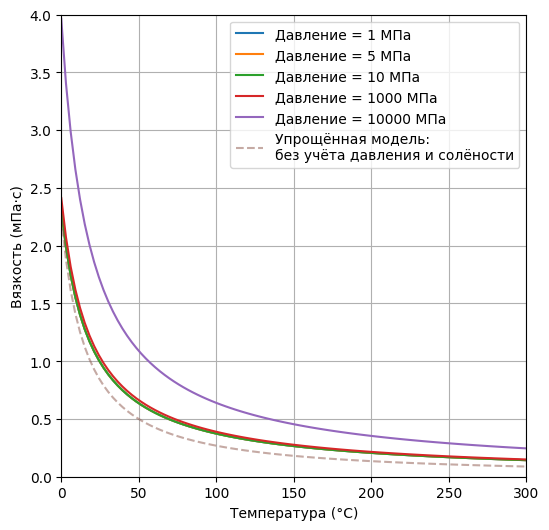

In [37]:
s = 10  # Salinity in %

#Define pressure values in MPa
pressure_mpa = np.array([1, 5, 10, 1000, 10000])  # Example pressures in MPa
pressure_psi = mp_to_psi(pressure_mpa)

# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, 100) # Start from 38°C to comply with constraints
temperature_array_F = celsius_to_fahrenheit(temperature_array_C)

# Plotting
plt.figure(figsize=(6, 6))

# Calculate viscosity for each temperature and pressure
for P in pressure_mpa:
    viscosity_values = [viscosity_McCain(s=s, T=T, P=P) for T in temperature_array_F]

    # Plot the viscosity for the current pressure
    # plt.plot(temperature_array_C, viscosity_values, label=f'Pressure = {P:} MPa')
    plt.plot(temperature_array_C, viscosity_values, label=f'Давление = {P:} МПа')

simplified_viscosity_values = [simplified_viscosity(T) for T in temperature_array_F]
# plt.plot(temperature_array_C, simplified_viscosity_values, '--', label='Simplified Model: no pressure, no salinity', alpha=0.5)
plt.plot(temperature_array_C, simplified_viscosity_values, '--',
         label='Упрощённая модель:\nбез учёта давления и солёности',
         alpha=0.5)
# Customize the plot
# plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
# plt.ylabel('Viscosity (mPa·s)')
# plt.xlabel('Temperature (°C)')
# plt.title('Вязкость солёной воды в зависимости от температуры при различных давлениях')
plt.ylabel('Вязкость (мПа·с)')
plt.xlabel('Температура (°C)')
plt.grid(True)
plt.legend()
plt.xlim(0, 300) # Set limits according to temperature range
plt.ylim(0, 4)

plt.savefig('Viscosity_McCain.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()

Normal calculation for various pressure values by Hewlett-Packard

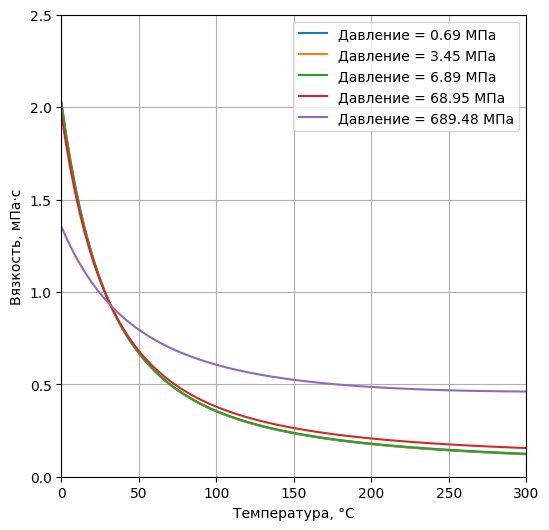

In [40]:
# Constants
s = 10  # Salinity in %

# Define pressure values in MPa
pressure_mpa = np.array([1, 5, 10, 100, 1000])  # Example pressures in MPa
pressure_psi = mp_to_psi(pressure_mpa) # Convert to psi
pressure_bar = mp_to_bar(pressure_mpa)


# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, 100)  # Corrected temperature range
temperature_array_K = temperature_array_C + 273.15  # Convert to Kelvin
temperature_array_F = (temperature_array_C * 9/5) + 32 # Convert to Fahrenheit

# Plotting
plt.figure(figsize=(6, 6))

# Calculate viscosity for each temperature and pressure
for P in pressure_bar:
    viscosity_values = [viscosity_HP(s=s, T=T, Tk=Tk, P=P) for T, Tk in zip(temperature_array_F , temperature_array_K)]
    viscosity_values = (list(map(lambda x: x * 10e2, viscosity_values)))

    # Plot the viscosity for the current pressure
    # plt.plot(temperature_array_C, viscosity_values, label=f'Pressure = {P:.2f} psi')
    plt.plot(temperature_array_C, viscosity_values,
         label=f'Давление = {P*0.0689476:.2f} МПа')  # конвертация psi в МПа

# Customize the plot
# plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
# plt.ylabel('Viscosity (mPa·s)')
# plt.xlabel('Temperature (°C)')
# plt.title('Зависимость вязкости солёной воды от температуры\nпри различных давлениях')
plt.ylabel('Вязкость, мПа·с')
plt.xlabel('Температура, °C')
plt.grid(True)
plt.legend()
plt.xlim(0, 300)  # Set limits according to temperature range
plt.ylim(0, 2.5)

plt.savefig('Viscosity_Hewlett-Packard.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()

Visualition as in book

In [ ]:
# image = cv2.imread('/content/Снимок экрана 2024-11-24 в 21.45.53.png')
# cv2_imshow(image)

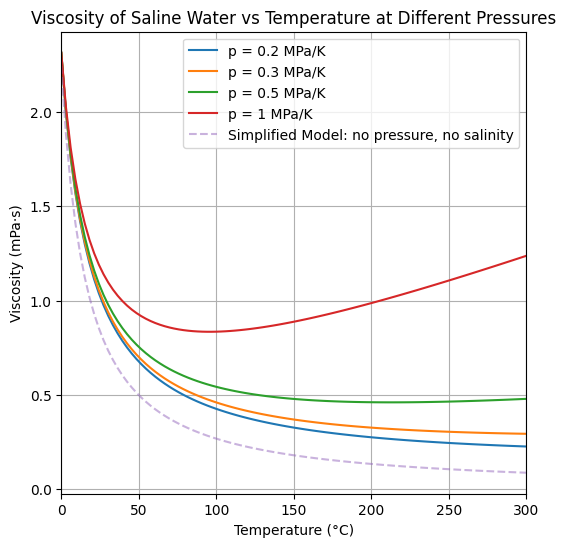

In [41]:
# Constants
s = 10  # Salinity in %

#Define pressure values in MPa
lowered_array = [0.2, 0.3, 0.5, 1]
N = 100 # point for ploting


# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, N) # Start from 38°C to comply with constraints
temperature_array_F = celsius_to_fahrenheit(temperature_array_C) # calculation in F

# Create an array of pressure (MPa)
pressure_mpa = np.linspace(0, 300,N)  # Example pressures in MPa

# Plotting
plt.figure(figsize=(6, 6))

for lower_value in lowered_array:
  lowered_pressure_mpa = np.array(list(map(lambda x: x * lower_value, pressure_mpa)))
  pressure_psi = mp_to_psi(lowered_pressure_mpa) # calculation in psi

  # Calculate viscosity for each temperature and pressure
  viscosity_values = [viscosity_McCain(s=s, T=T, P=P) for T, P in zip(temperature_array_F, pressure_psi)]
  plt.plot(temperature_array_C, viscosity_values, label=f'p = {lower_value:} MPa/K')

simplified_viscosity_values = [simplified_viscosity(T) for T in temperature_array_F]
plt.plot(temperature_array_C, simplified_viscosity_values, '--', label='Simplified Model: no pressure, no salinity', alpha=0.5)
plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
plt.ylabel('Viscosity (mPa·s)')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.xlim(0, 300)
plt.show()

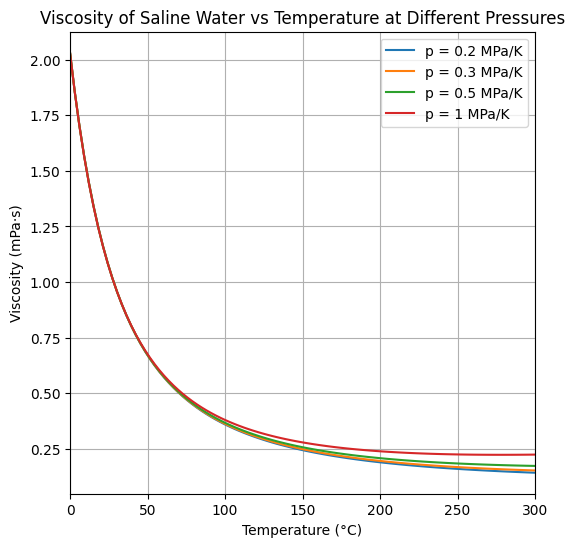

In [42]:
# Constants
s = 10  # Salinity in %

#Define pressure values in MPa
lowered_array = [0.2, 0.3, 0.5, 1]
N = 100 # point for ploting

# Create an array of temperatures (C)
temperature_array_C = np.linspace(0, 300, N) # Start from 38°C to comply with constraints
temperature_array_F = celsius_to_fahrenheit(temperature_array_C) # calculation in F
temperature_array_K = temperature_array_C + 273.15  # Convert to Kelvin

# Create an array of pressure (MPa)
pressure_mpa = np.linspace(0, 300, N)  # Example pressures in MPa


# Plotting
plt.figure(figsize=(6, 6))

for lower_value in lowered_array:
  lowered_pressure_mpa = np.array(list(map(lambda x: x * lower_value, pressure_mpa)))
  pressure_bar = mp_to_bar(lowered_pressure_mpa)

  # Calculate viscosity for each temperature and pressure
  viscosity_values = [viscosity_HP(s=s, T=T, Tk=Tk, P=P) for T, P, Tk in zip(temperature_array_F, pressure_bar, temperature_array_K)]
  viscosity_values = (list(map(lambda x: x * 10e2, viscosity_values)))
  plt.plot(temperature_array_C, viscosity_values, label=f'p = {lower_value:} MPa/K')

plt.title('Viscosity of Saline Water vs Temperature at Different Pressures')
plt.ylabel('Viscosity (mPa·s)')
plt.xlabel('Temperature (°C)')
plt.grid(True)
plt.legend()
plt.xlim(0, 300)
plt.show()

# Permeability

In [ ]:
# image = cv2.imread('/content/Снимок экрана 2024-11-24 в 22.37.46.png')
# cv2_imshow(image)

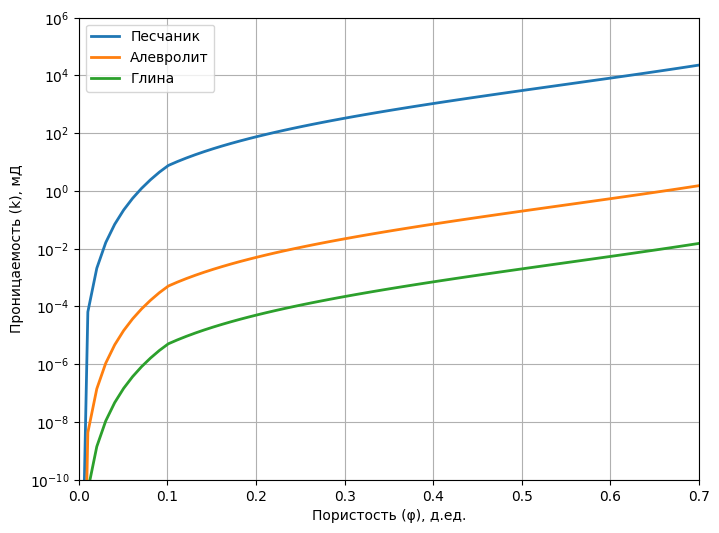

In [3]:
def Kozeny_Carman(r, phi, tau):
    return r**2 * phi / (8 * tau**2)

def Kozeny_Carman_lithology(phi, k, S):
    phi_corrected = phi - 3.1 * 10e-10
    if phi_corrected < 0.1:
        return 2 * 10**16 * k * (phi_corrected**5 / (S**2 * (1 - phi_corrected)**2))
    else:
        return 2 * 10**14 * k * (phi_corrected**3 / (S**2 * (1 - phi_corrected)**2))

# Define lithology properties
shale = {
    'spec. surf. area': 10**8,
    'k': 0.2
}

siltstone = {
    'spec. surf. area': 10**7,
    'k': 0.2
}

sandstone = {
    'spec. surf. area': 10**6,
    'k': 30.0
}

lithology_types = ['sandstone', 'siltstone', 'shale']
lithology_dict = {
    'sandstone': 'Песчаник',
    'limestone': 'Известняк',
    'dolomite': 'Доломит',
    'shale': 'Глина',
    'siltstone': 'Алевролит'
}



# Create an array of porosities
phi_array = np.linspace(0.00001, 1, 100)  # Start from a small positive value

plt.figure(figsize=(8, 6))

# Loop through each lithology and calculate effective stress
for lithology in lithology_types:
    if lithology == 'sandstone':
        k = sandstone['k']
        SSA = sandstone['spec. surf. area']
    elif lithology == 'siltstone':
        k = siltstone['k']
        SSA = siltstone['spec. surf. area']
    elif lithology == 'shale':
        k = shale['k']
        SSA = shale['spec. surf. area']

    # Calculate permeability for the current lithology
    permeability = [Kozeny_Carman_lithology(phi, k=k, S=SSA) for phi in phi_array]
    conversion_factor = 0.98692*10**-15 # Convert m² to D
    permeability_md = (list(map(lambda x: x * conversion_factor, permeability)))
    # permeability_KZ = [Kozeny_Carman(phi, k=k, S=SSA) for phi in phi_array]

    # Plot the permeability for the current lithology
    # plt.plot(phi_array, permeability_md, label=f'{lithology.capitalize()}', linewidth=2)
    # plt.plot(phi_array, permeability, label=f'{lithology.capitalize()}', linewidth=2)
    plt.plot(phi_array, permeability,
         label=lithology_dict.get(lithology.lower(), lithology.capitalize()),
         linewidth=2)

# Customize the plot
# plt.title('Permeability vs Porosity for Different Lithologies')
# plt.xlabel('Porosity (φ)')
# plt.ylabel('Permeability (mD)')
# plt.title('Зависимость проницаемости от пористости\nдля различных литотипов')
plt.xlabel('Пористость (φ), д.ед.')
plt.ylabel('Проницаемость (k), мД')
plt.grid(True)
plt.xlim(0, 0.7)
plt.ylim(10e-11, 10**6)

# Set y-axis to logarithmic scale
plt.yscale('log')
plt.legend()

plt.savefig('Permeability_Porosity.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()

In [ ]:

hydrostatic_pressures, lithostatic_pressures = pressure(['hydrostatic', 'lithostatic'])

# Calculate differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Display the results
print("Pressure Differences (Lithostatic - Hydrostatic):")
print(pressure_differences)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
C = 10**-4       # Constant C
k = 10           # Permeability k
nu = pressure_differences        # Viscosity nu
L = 5            # Length of the domain in z (km)
T = 10           # Total time (seconds)
dz = 0.5         # Spatial step size (km)
dt = 0.01        # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        du_dt = (k / nu) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C * du_dt + C * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
C_values = np.array([10**-4, 2 * 10**-4, 5 * 10**-4])  # Array of constants C
k_values = np.array([10, 20, 30])                        # Array of permeabilities k
nu = 1e-3                                               # Viscosity nu (example value)
L = 5                                                   # Length of the domain in km
T = 10                                                  # Total time (seconds)
dz = 0.5                                                # Spatial step size (km)
dt = 0.01                                               # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays for pressure and u
u = np.zeros((len(C_values), z_points))               # Solution array for u with shape (len(C), z_points)
u_l = np.zeros(t_points)                                # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)                             # Example: sinusoidal variation

# Time-stepping loop for each constant C and permeability k
for t in range(1, t_points):
    for c_index in range(len(C_values)):
        C = C_values[c_index]
        k = k_values[c_index]

        for z in range(1, z_points - 1):
            du_dt = (k / nu) * (u[c_index, z + 1] - 2 * u[c_index, z] + u[c_index, z - 1]) / (dz**2)  # Central difference in space
            u[c_index, z] += dt * (C * du_dt + C * (u_l[t] - u[c_index, z]))  # Update rule based on the equation

# Calculate pressure from the final solution u
pressure = np.zeros_like(u)                           # Initialize pressure array
for c_index in range(len(C_values)):
    pressure[c_index] = u[c_index] * nu               # Example relationship: pressure proportional to u

# Plotting the results for each combination of C and k
z_array = np.linspace(0, L, z_points)

plt.figure(figsize=(12, 10))

for c_index in range(len(C_values)):
    plt.subplot(len(C_values), 1, c_index + 1)
    plt.plot(u[c_index], z_array, label=f'Final Solution for u(z), C={C_values[c_index]}, k={k_values[c_index]}', color='blue')
    plt.title(f'Solution of the PDE using Finite Difference Method\nC={C_values[c_index]}, k={k_values[c_index]}')
    plt.ylabel('Distance (z) [km]')
    plt.xlabel('u(z)')
    plt.grid(True)
    plt.legend()
    plt.gca().invert_yaxis()                            # Invert y-axis for distance

plt.tight_layout()
plt.show()

# Plotting pressure results
plt.figure(figsize=(12, 6))
for c_index in range(len(C_values)):
    plt.plot(pressure[c_index], z_array, label=f'Pressure Profile for C={C_values[c_index]}, k={k_values[c_index]}', color='orange')

plt.title('Pressure Profiles')
plt.ylabel('Distance (z) [km]')
plt.xlabel('Pressure')
plt.grid(True)
plt.legend()
plt.gca().invert_yaxis()                              # Invert y-axis for distance
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100           # Permeability k
L = 6            # Length of the domain in z (km) - adjusted to match depth range
T = 10           # Total time (seconds)
dz = 1           # Spatial step size (km)
dt = 0.01        # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Use pressure difference corresponding to current depth z
        nu = pressure_differences[z] if z < len(pressure_differences) else pressure_differences[-1]

        du_dt = (k / nu) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C * du_dt + C * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(z_array)
print(u)
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.plot(hydrostatic_pressures, z_array, label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array, label='Lithostatic', color='red')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100      # Permeability k
L = 6        # Length of the domain in z (km)
T = 10       # Total time (seconds)
dz = 1       # Spatial step size (km)
dt = 0.01    # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
u = np.zeros(z_points)        # Solution array for u
u_l = np.zeros(t_points)      # Assume some known function for u_l

# Example: Define u_l as a function of time (could be any function)
for t in range(t_points):
    u_l[t] = np.sin(t * dt)  # Example: sinusoidal variation

# Define porosity as a function of depth (example values)
phi = np.linspace(0.1, 0.1, z_points)  # Porosity values from 0.1 to 0.4

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Calculate effective viscosity based on porosity
        nu_eff = pressure_differences[z] / (1 - phi[z]) if phi[z] < 1 else pressure_differences[z]

        du_dt = (k / nu_eff) * (u[z + 1] - 2 * u[z] + u[z - 1]) / (dz**2)  # Central difference in space
        u[z] += dt * (C / (1 - phi[z]) * du_dt + C / (1 - phi[z]) * (u_l[t] - u[z]))  # Update rule based on the equation

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(z_array)
print(u)

u = -u*10**2
plt.figure(figsize=(6, 10))
plt.plot(u, z_array, label='Final Solution for u(z)', color='blue')
plt.plot(hydrostatic_pressures, z_array, label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array, label='Lithostatic', color='red')
plt.title('Solution of the PDE using Finite Difference Method')
plt.ylabel('Distance (z)')
plt.xlabel('u(z)')
plt.grid(True)
plt.legend()

# Invert y-axis
plt.gca().invert_yaxis()

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given pressures (example values for hydrostatic and lithostatic)
hydrostatic_pressures = [0, 10.2024, 20.4048, 30.6072, 40.8096, 51.0120, 61.2144]
lithostatic_pressures = [0, 26.4870, 52.9740, 79.4610, 105.9480, 132.4350, 158.9220]

# Calculate pressure differences
pressure_differences = [litho - hydro for litho, hydro in zip(lithostatic_pressures, hydrostatic_pressures)]

# Parameters
C = 10       # Constant C
k = 100      # Permeability k
nu = 1.0     # Viscosity nu
L = 6        # Length of the domain in z (km)
T = 10       # Total time (seconds)
dz = 1       # Spatial step size (km)
dt = 0.01    # Time step size (seconds)

# Derived parameters
z_points = int(L / dz) + 1
t_points = int(T / dt) + 1

# Initialize arrays
P = np.zeros(z_points)        # Solution array for pressure P
P_l = np.zeros(t_points)      # Assume some known function for Pl

# Set P_l equal to pressure differences over time
for t in range(t_points):
    P_l[t] = pressure_differences[min(t, len(pressure_differences)-1)]  # Use last value if t exceeds length

# Define porosity as a function of depth (example values)
phi = np.linspace(0.1, 0.1, z_points)  # Porosity values from 0.1 to 0.4

# Time-stepping loop
for t in range(1, t_points):
    for z in range(1, z_points - 1):
        # Calculate effective viscosity based on porosity
        nu_eff = nu / (1 - phi[z]) if phi[z] < 1 else nu

        # Central difference in space and time
        dP_dt = (k / nu_eff) * (P[z + 1] - 2 * P[z] + P[z - 1]) / (dz**2)

        # Update rule based on the equation
        P[z] += dt * (C / (1 - phi[z]) * dP_dt + C / (1 - phi[z]) * (P_l[t] - P[z]))

# Plotting the results
z_array = np.linspace(0, L, z_points)
print(P)
plt.figure(figsize=(6, 10))
plt.plot(P, z_array, label='Final Pressure Profile', color='blue')
plt.plot(hydrostatic_pressures, z_array[:len(hydrostatic_pressures)], label='Hydrostatic', color='black')
plt.plot(lithostatic_pressures, z_array[:len(lithostatic_pressures)], label='Lithostatic', color='red')
plt.title('Pressure Distribution Over Depth')
plt.ylabel('Depth (z)')
plt.xlabel('Pressure P')
plt.grid(True)
plt.legend()

# Invert y-axis for depth representation
plt.gca().invert_yaxis()

plt.show()